# Constrained Concept Refinement (CCR) Demo: Interpretable Digit Classification

This notebook demonstrates the effect of **Constrained Concept Refinement (CCR)** on **Concept Bottleneck Models (CBMs)** for interpretable machine learning on the digits dataset.
We compare three approaches:

1. **Baseline CBM**: Logistic regression on human-defined concepts.
2. **Deep CBM (Unconstrained)**: End-to-end learning of concepts from images.
3. **CCR (Constrained)**: Regularized to align learned concepts with human concepts.

**Key Concepts Computed**:
- **Ink Density**: Average pixel intensity (0-1).
- **Vertical Symmetry**: Similarity between left/right halves (0-1, higher = more symmetric).
- **Horizontal Symmetry**: Similarity between top/bottom halves (0-1).
- **Top Heavy**: Ratio of ink in top half vs. bottom half (>1 means more ink on top).
- **Left Heavy**: Ratio of ink in left half vs. right half (>1 means more ink on left).
- **Center of Mass (X/Y)**: Weighted average position of ink (0-7 for 8x8 images).

The notebook evaluates **accuracy**, **concept fidelity** (how well learned concepts match human ones), and provides **visual examples**.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim

np.random.seed(42)
torch.manual_seed(42)

digits = load_digits()
X = digits.images / 16.0  # normalize
y = digits.target

n, H, W = X.shape
X_flat = X.reshape(n, -1)

In [2]:
def compute_concepts(batch_images):
    B = batch_images.shape[0]
    concepts = np.zeros((B, 7), dtype=np.float32)
    eps = 1e-6
    for i in range(B):
        img = batch_images[i]
        ink_density = img.mean()
        left, right = img[:, :4], img[:, 4:]
        right_mirror = np.fliplr(right)
        vert_sym = 1.0 - (
            np.abs(left - right_mirror).sum()
            / (np.abs(left).sum() + np.abs(right_mirror).sum() + eps)
        )
        top, bottom = img[:4, :], img[4:, :]
        bottom_mirror = np.flipud(bottom)
        horiz_sym = 1.0 - (
            np.abs(top - bottom_mirror).sum()
            / (np.abs(top).sum() + np.abs(bottom_mirror).sum() + eps)
        )
        top_heavy_ratio = top.sum() / (bottom.sum() + eps)
        left_heavy_ratio = left.sum() / (right.sum() + eps)
        coords_x = np.arange(W)[None, :].repeat(H, axis=0)
        coords_y = np.arange(H)[:, None].repeat(W, axis=1)
        total_mass = img.sum() + eps
        com_x = (img * coords_x).sum() / total_mass
        com_y = (img * coords_y).sum() / total_mass
        concepts[i] = np.array(
            [
                ink_density,
                vert_sym,
                horiz_sym,
                top_heavy_ratio,
                left_heavy_ratio,
                com_x,
                com_y,
            ],
            dtype=np.float32,
        )
    return concepts


C_human = compute_concepts(X)

In [3]:
Xtr, Xte, ytr, yte, Ch_tr, Ch_te = train_test_split(
    X, y, C_human, test_size=0.3, random_state=42, stratify=y
)
Xtr_flat = Xtr.reshape(len(Xtr), -1)
Xte_flat = Xte.reshape(len(Xte), -1)

scaler = StandardScaler()
Ch_tr_std = scaler.fit_transform(Ch_tr)
Ch_te_std = scaler.transform(Ch_te)

# CBM baseline
clf_cbm = LogisticRegression(max_iter=1000)
clf_cbm.fit(Ch_tr_std, ytr)
yhat_cbm = clf_cbm.predict(Ch_te_std)
acc_cbm = accuracy_score(yte, yhat_cbm)

# Torch prep
device = torch.device("cpu")
Xtr_t = torch.tensor(Xtr_flat, dtype=torch.float32, device=device)
Xte_t = torch.tensor(Xte_flat, dtype=torch.float32, device=device)
ytr_t = torch.tensor(ytr, dtype=torch.long, device=device)
yte_t = torch.tensor(yte, dtype=torch.long, device=device)
Ch_tr_std_t = torch.tensor(Ch_tr_std, dtype=torch.float32, device=device)
Ch_te_std_t = torch.tensor(Ch_te_std, dtype=torch.float32, device=device)

input_dim = Xtr_t.shape[1]
concept_dim = Ch_tr_std.shape[1]
num_classes = 10

In [4]:
class ConceptNet(nn.Module):
    def __init__(self, in_dim, concept_dim, hidden=32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden), nn.ReLU(), nn.Linear(hidden, concept_dim)
        )

    def forward(self, x):
        return self.net(x)


class LabelNet(nn.Module):
    def __init__(self, concept_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(concept_dim, num_classes)

    def forward(self, z):
        return self.fc(z)


def train_deep_cbm(
    alpha_ccr=0.0, epochs=50, lr=1e-3, weight_decay=1e-4, batch_size=256
):
    concept_model = ConceptNet(input_dim, concept_dim).to(device)
    label_model = LabelNet(concept_dim, num_classes).to(device)
    ce_loss = nn.CrossEntropyLoss()
    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(
        list(concept_model.parameters()) + list(label_model.parameters()),
        lr=lr,
        weight_decay=weight_decay,
    )
    ntrain = Xtr_t.shape[0]
    steps = int(np.ceil(ntrain / batch_size))
    for ep in range(epochs):
        perm = torch.randperm(ntrain, device=device)
        for s in range(steps):
            idx = perm[s * batch_size : (s + 1) * batch_size]
            xb, yb, hb = Xtr_t[idx], ytr_t[idx], Ch_tr_std_t[idx]
            optimizer.zero_grad()
            zb = concept_model(xb)
            logits = label_model(zb)
            loss = ce_loss(logits, yb) + alpha_ccr * mse_loss(zb, hb)
            loss.backward()
            optimizer.step()
    with torch.no_grad():
        zte = concept_model(Xte_t)
        logits_te = label_model(zte)
        yhat_te = torch.argmax(logits_te, dim=1).cpu().numpy()
        acc_te = accuracy_score(yte, yhat_te)
        zte_np = zte.cpu().numpy()
        rmse = np.sqrt(((zte_np - Ch_te_std) ** 2).mean())
        cors = []
        for k in range(concept_dim):
            zk, hk = zte_np[:, k], Ch_te_std[:, k]
            if zk.std() < 1e-8 or hk.std() < 1e-8:
                cors.append(0.0)
            else:
                cors.append(float(np.corrcoef(zk, hk)[0, 1]))
    return {
        "concept_model": concept_model,
        "label_model": label_model,
        "test_acc": acc_te,
        "concept_rmse": rmse,
        "concept_cors": cors,
    }

In [5]:
res_unconstrained = train_deep_cbm(alpha_ccr=0.0, epochs=50)
res_ccr = train_deep_cbm(alpha_ccr=1.0, epochs=50)

accs = {
    "CBM (logreg on concepts)": acc_cbm,
    "Deep CBM (unconstrained)": res_unconstrained["test_acc"],
    "CCR (constrained)": res_ccr["test_acc"],
}
metrics_df = pd.DataFrame(
    {"Model": list(accs.keys()), "Test Accuracy": list(accs.values())}
)

In [6]:
# Summary Statistics
print("Overall Concept Correlations (Mean Absolute r):")
print(
    f"Unconstrained Deep CBM: {np.mean(np.abs(res_unconstrained['concept_cors'])):.3f}"
)
print(f"CCR: {np.mean(np.abs(res_ccr['concept_cors'])):.3f}")
print()
print("Accuracy Summary:")
for model, acc in accs.items():
    print(f"{model}: {acc:.3f}")
print()
print("Concept Fidelity (RMSE):")
print(f"Unconstrained Deep CBM: {res_unconstrained['concept_rmse']:.3f}")
print(f"CCR: {res_ccr['concept_rmse']:.3f}")

Overall Concept Correlations (Mean Absolute r):
Unconstrained Deep CBM: 0.142
CCR: 0.745

Accuracy Summary:
CBM (logreg on concepts): 0.674
Deep CBM (unconstrained): 0.874
CCR (constrained): 0.781

Concept Fidelity (RMSE):
Unconstrained Deep CBM: 2.834
CCR: 0.707


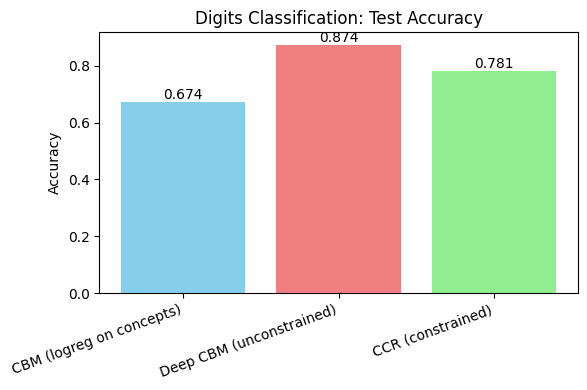

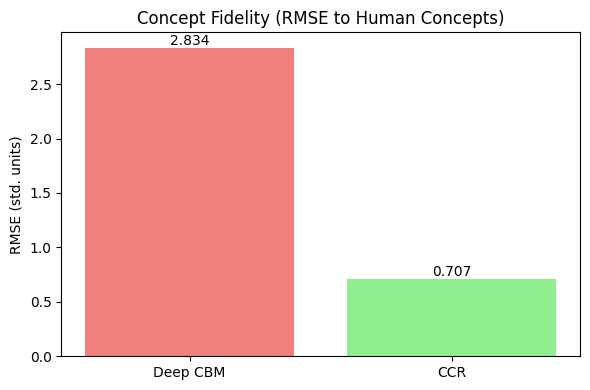

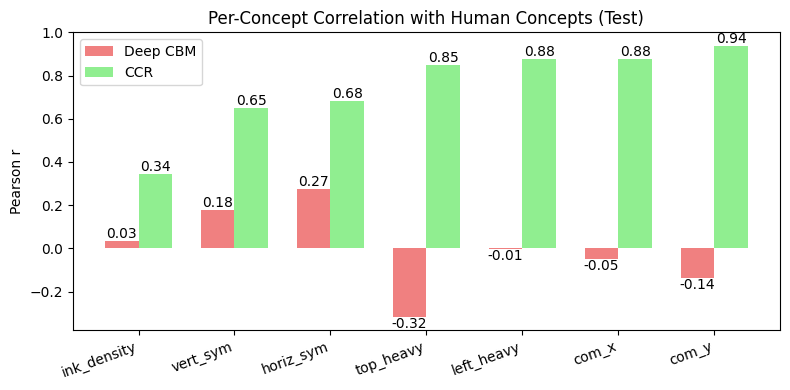

In [7]:
plt.figure(figsize=(6, 4))
bars = plt.bar(
    metrics_df["Model"],
    metrics_df["Test Accuracy"],
    color=["skyblue", "lightcoral", "lightgreen"],
)
plt.bar_label(bars, fmt="%.3f")
plt.title("Digits Classification: Test Accuracy")
plt.ylabel("Accuracy")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

rmse_vals = [np.nan, res_unconstrained["concept_rmse"], res_ccr["concept_rmse"]]
plt.figure(figsize=(6, 4))
bars = plt.bar(
    ["CBM (n/a)", "Deep CBM", "CCR"],
    rmse_vals,
    color=["gray", "lightcoral", "lightgreen"],
)
plt.bar_label(bars, fmt="%.3f")
plt.title("Concept Fidelity (RMSE to Human Concepts)")
plt.ylabel("RMSE (std. units)")
plt.tight_layout()
plt.show()

labels_concepts = [
    "ink_density",
    "vert_sym",
    "horiz_sym",
    "top_heavy",
    "left_heavy",
    "com_x",
    "com_y",
]
x = np.arange(len(labels_concepts))
width = 0.35
plt.figure(figsize=(8, 4))
bars1 = plt.bar(
    x - width / 2,
    res_unconstrained["concept_cors"],
    width,
    label="Deep CBM",
    color="lightcoral",
)
bars2 = plt.bar(
    x + width / 2, res_ccr["concept_cors"], width, label="CCR", color="lightgreen"
)
plt.bar_label(bars1, fmt="%.2f")
plt.bar_label(bars2, fmt="%.2f")
plt.title("Per-Concept Correlation with Human Concepts (Test)")
plt.ylabel("Pearson r")
plt.xticks(x, labels_concepts, rotation=20, ha="right")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
# Show 5 sample images + concept comparison table
with torch.no_grad():
    z_ccr = res_ccr["concept_model"](Xte_t).cpu().numpy()
Ch_te_unstd = scaler.inverse_transform(Ch_te_std)
z_ccr_unstd = scaler.inverse_transform(z_ccr)
idxs = np.random.choice(len(Xte), size=5, replace=False)
rows = []
for i in idxs:
    row = {"true_label": int(yte[i])}
    for k, name in enumerate(labels_concepts):
        row[f"human_{name}"] = round(float(Ch_te_unstd[i, k]), 2)
        row[f"CCR_{name}"] = round(float(z_ccr_unstd[i, k]), 2)
    rows.append(row)
viz_df = pd.DataFrame(rows)
print("Sample: Human vs CCR Concepts (unstd units)")
viz_df

Sample: Human vs CCR Concepts (unstd units)


,true_label,human_ink_density,CCR_ink_density,human_vert_sym,CCR_vert_sym,human_horiz_sym,CCR_horiz_sym,human_top_heavy,CCR_top_heavy,human_left_heavy,CCR_left_heavy,human_com_x,CCR_com_x,human_com_y,CCR_com_y
0,8,0.30,0.32,0.65,0.78,0.71,0.83,0.99,1.11,1.15,0.98,3.44,3.38,3.51,3.38
1,7,0.28,0.28,0.62,0.57,0.56,0.55,1.21,1.15,1.07,1.13,3.50,3.81,3.01,2.78
2,9,0.29,0.30,0.68,0.73,0.64,0.73,1.99,1.89,0.71,0.51,3.76,3.76,3.03,2.87
3,5,0.30,0.27,0.57,0.46,0.54,0.51,1.49,1.56,1.24,1.42,3.31,3.30,3.17,3.01
4,0,0.31,0.34,0.65,0.83,0.86,0.74,1.18,0.99,1.08,1.00,3.60,3.47,3.28,3.37


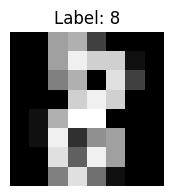

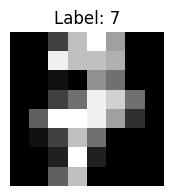

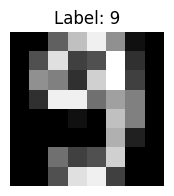

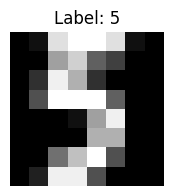

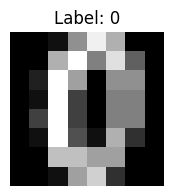

In [9]:
for i in idxs:
    plt.figure(figsize=(2, 2))
    plt.imshow(Xte[i], cmap="gray")
    plt.title(f"Label: {yte[i]}")
    plt.axis("off")
    plt.show()